# Import

In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
region = "MIMAROPA"
mother_directory = f"/content/drive/MyDrive/MS thesis/[optimize] Training, Testing/{region}/"
# raw_rg1_clustered = pd.read_csv("/content/drive/MyDrive/MS thesis/preliminary site selection/CALABARZON/calabarzon_clusters.csv")
raw_rg1_clustered = pd.read_csv(mother_directory + "PCF_data.csv")
# use pcf data nalang para you dont get nans for sure?

neighbors_df = pd.read_csv(mother_directory + 'mimaropa_neighbours.csv')
candidate_sites = pd.read_csv(mother_directory + "candidate_sites.csv")
candidate_sites

'''AGGREGATING THE POPULATION'''
# Assuming df is your DataFrame
# vp =  raw_rg1_clustered['popden_chi'] + raw_rg1_clustered['popden_eld'] + raw_rg1_clustered['popden_wom'] + raw_rg1_clustered['popden_you'] + raw_rg1_clustered['popden_w_1'] + raw_rg1_clustered['popden_you']
# gen = raw_rg1_clustered['popden_all'] - vp
# all = vp + gen
# raw_rg1_clustered['total_population'] = all
# raw_rg1_clustered.columns

# raw_rg1_clustered = raw_rg1_clustered.drop(columns=['Unnamed: 0'])
neighbors_df.rename(columns={'fid': 'ID'}, inplace=True)
# raw_rg1_clustered = raw_rg1_clustered.drop(columns=['HCFAI.1'])
raw_rg1_clustered.columns

Index(['flood_probability_value', 'rain intensity_value', 'drought_value',
       'Distance_to_Nearest_RHU_km', 'popden_chi', 'popden_eld', 'popden_all',
       'popden_wom', 'popden_w_1', 'popden_you', 'HCFAI', 'total_population',
       'RHU_Presence', 'ID', 'buildability_landcov', 'Road_Presence',
       'POI_Presence', 'Nearest_RHU', 'Cluster'],
      dtype='object')

In [3]:
def HCI_calc(total_ai, total_gi, total_hi, total_ji, total_ki, total_mi, distance, road_bi, POI_ci, landCov_di, hazard1_ei, hazard2_ei, hazard3_ei, rhus_fi):
    total_vulnerable = total_gi + total_hi + total_ji + total_ki + total_mi
    total_pop = total_ai
    population_to_be_served = total_vulnerable + np.maximum(0, total_pop - total_vulnerable)
    y = np.where(population_to_be_served == 0, 0, 20000 / ((population_to_be_served) * (distance + rhus_fi)))
    mc = np.tanh(y)
    w_bi = 0.3  # roads
    w_ci = 0.2  # POIs
    w_di = 0.5  # land cov
    b = (POI_ci * w_ci) + (road_bi * w_bi) + (landCov_di * w_di)
    rain_intensity_normalized = (hazard1_ei - hazard1_ei.min()) / (hazard1_ei.max() - hazard1_ei.min())
    flood_probability_normalized = (hazard2_ei - hazard2_ei.min()) / (hazard2_ei.max() - hazard2_ei.min())
    drought_mean_normalized = (hazard3_ei - hazard3_ei.min()) / (hazard3_ei.max() - hazard3_ei.min())
    w_rain = 0.4
    w_flood = 0.3
    w_drought = 0.3
    c = (w_rain * rain_intensity_normalized) + (w_flood * flood_probability_normalized) + (w_drought * drought_mean_normalized)
    f = b - c
    f = np.tanh(f)
    hci = mc * f
    hcfai = (1 + np.tanh(hci / 2)) / 2  # Sigmoid function

    return hcfai

def overallHCFAI(region_df):
    if 'HCFAI' in region_df.columns:
        HCFAI_overall = region_df['HCFAI'].sum()
    elif 'new HCFAI' in region_df.columns:
        HCFAI_overall = region_df['new HCFAI'].sum()
    return HCFAI_overall

def selectTopSites(candidate_sites, region_df, selected_sites, n):
    if len(selected_sites) < n:  # if optimal and existing RHUs list is incomplete
        while len(selected_sites) < n:
            new_site = candidate_sites.iloc[:1].copy()
            selected_sites = pd.concat([selected_sites, new_site], ignore_index=True)
            candidate_sites = candidate_sites.drop(candidate_sites.index[0]).reset_index(drop=True)

    # region_df = region_df.drop('total_population', axis=1)

    columns_to_merge = ['ID',
                        'popden_chi', 'popden_eld', 'popden_wom', 'popden_you', 'popden_w_1',
                        'popden_all', 'flood_probability_value', 'rain intensity_value',
                        'drought_value', 'buildability_landcov', 'RHU_Presence',
                        'Road_Presence', 'POI_Presence', 'Nearest_RHU',
                        'Distance_to_Nearest_RHU_km']

    merged_sites = candidate_sites.merge(region_df[columns_to_merge], on='ID', how='left')
    merged_sites['HCFAI'] = HCI_calc(merged_sites['popden_all'],
                                     merged_sites['popden_chi'],
                                     merged_sites['popden_eld'],
                                     merged_sites['popden_wom'],
                                     merged_sites['popden_you'],
                                     merged_sites['popden_w_1'],
                                     merged_sites['Distance_to_Nearest_RHU_km'],
                                     merged_sites['Road_Presence'],
                                     merged_sites['POI_Presence'],
                                     merged_sites['buildability_landcov'],
                                     merged_sites['rain intensity_value'],
                                     merged_sites['flood_probability_value'],
                                     merged_sites['drought_value'],
                                     merged_sites['RHU_Presence'],
                                     )

    missing_cols = [col for col in region_df.columns if col != 'ID']
    for col in missing_cols:
        if 'ID' not in region_df.columns:
            region_df.set_index('ID', inplace=True)
        merged_sites[col] = merged_sites[col].fillna(region_df[col])

    top_sites = merged_sites.sort_values(by='HCFAI', ascending=False).head(n)
    return top_sites

def removeAdjacentSites(region_df, candidate_sites, selected_sites, neighbors_df, n):
    idx_with_RHU = region_df[region_df['RHU_Presence'] == 1]
    adjacent_sites = set()
    with_RHU_indices = selected_sites['ID'].tolist()
    for site_id in selected_sites['ID']:
        if site_id in neighbors_df['ID'].values:
            neighbors = neighbors_df.loc[neighbors_df['ID'] == site_id, 'neighbours'].iloc[0]
            adjacent_sites.update(neighbors.split(','))
    adjacent_sites.update(idx_with_RHU['ID'])
    adjacent_sites.update(selected_sites['ID'])
    adjacent_sites = [int(site) for site in adjacent_sites]
    candidate_sites = candidate_sites[~candidate_sites['ID'].isin(adjacent_sites)].reset_index(drop=True)

    # print(f"{len(candidate_sites)} Candidate sites left")
    # print(f"This is what we'll put on QGIS: {selected_sites['ID'].tolist()}")

    if len(candidate_sites) > n:
      for i in with_RHU_indices:
          # print(f"Site {i} has the following sites to choose from: {candidate_sites['ID'].tolist()}")
          if i in adjacent_sites:
              # print(f"Site {i} was highkey sus for not saying they have neighbors ...")
              with_RHU_indices.remove(i)
              selected_sites = selected_sites.drop(selected_sites[selected_sites['ID'] == i].index).reset_index(drop=True)
    elif len(candidate_sites) <= n:
      return candidate_sites, selected_sites, idx_with_RHU

    selected_sites['HCFAI'] = HCI_calc(selected_sites['popden_all'], selected_sites['popden_chi'],
                                       selected_sites['popden_eld'], selected_sites['popden_wom'],
                                       selected_sites['popden_you'], selected_sites['popden_w_1'],
                                       selected_sites['Distance_to_Nearest_RHU_km'],
                                       selected_sites['Road_Presence'], selected_sites['POI_Presence'],
                                       selected_sites['buildability_landcov'], selected_sites['rain intensity_value'],
                                       selected_sites['flood_probability_value'], selected_sites['drought_value'],
                                       selected_sites['RHU_Presence'])
    return candidate_sites, selected_sites, idx_with_RHU

def optimize(region_df, candidate_sites, neighbors_df, num_facilities):
    original_HCFAI = overallHCFAI(region_df)
    # print("Original HCFAI:", original_HCFAI)
    # print(region_df.columns)
    region_df = region_df.drop(['total_population'], axis=1)
    selected_sites = pd.DataFrame(columns=region_df.columns)
    top_sites = selectTopSites(candidate_sites, region_df, selected_sites, num_facilities - len(selected_sites))

    while len(selected_sites) < num_facilities:
        # candidate_sites, top_sites, idx_with_RHU = removeAdjacentSites(region_df, candidate_sites, top_sites, neighbors_df, num_facilities)
        if len(candidate_sites) <= num_facilities:
          top_sites = candidate_sites
        elif len(candidate_sites) > num_facilities:
          top_sites = selectTopSites(candidate_sites, region_df, selected_sites, num_facilities - len(selected_sites))
          selected_sites = top_sites

        candidate_sites, top_sites, idx_with_RHU = removeAdjacentSites(region_df, candidate_sites, top_sites, neighbors_df, num_facilities)
        selected_sites = pd.concat([selected_sites, top_sites]).reset_index(drop=True)
        remaining_sites = region_df[~region_df['ID'].isin(selected_sites['ID'])] # HCFAI did not change

        selected_sites['RHU_Presence'] = 1
        remaining_HCFAI = overallHCFAI(remaining_sites)
        selected_sites_HCFAI = overallHCFAI(selected_sites)
        updated_HCFAI = remaining_HCFAI + selected_sites_HCFAI

         # Assuming df is your DataFrame
        vp =  selected_sites['popden_chi'] + selected_sites['popden_eld'] + selected_sites['popden_wom'] + selected_sites['popden_you'] + selected_sites['popden_w_1'] + selected_sites['popden_you']
        gen = selected_sites['popden_all'] - vp
        all = vp + gen
        selected_sites['total_population'] = all
        print(selected_sites['total_population']) # trying to see how much more of the population gets healthcare access

        # places_with_rhu = region_df.copy()
        # x = region_df[region_df['RHU_Presence' == 1]]
        # print(x['total_population'])

        # print("Updated HCFAI:", updated_HCFAI)
        # print(f"{len(selected_sites)} selected sites")

        if len(selected_sites) == num_facilities:
            print("Accept!!!!!!!!!!!!!!")
            return selected_sites, idx_with_RHU, original_HCFAI, updated_HCFAI

        elif len(candidate_sites) <= num_facilities:
            return selected_sites, idx_with_RHU, original_HCFAI, updated_HCFAI

        else:
            print("Reject!!!!!!!!!!!!!!")
            print("Selected sites:", len(selected_sites))
            top_sites = selectTopSites(candidate_sites, region_df, selected_sites, num_facilities - len(selected_sites))

    return selected_sites, idx_with_RHU, original_HCFAI, updated_HCFAI

# Trained rg1 data model

In [ ]:
print(f"Candidate sites: {len(candidate_sites)}")
# Optimize selection of health facility sites
PCF =284
selected_facilities, hex_with_RHU, og_HCFAI, updated_HCFAI = optimize(raw_rg1_clustered, candidate_sites, neighbors_df, PCF)
print(selected_facilities.to_string(index=False))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
selected_facilities = list(selected_facilities['ID'])
hex_with_RHU = list(hex_with_RHU['ID'])
hex_with_RHU
print(f"Optimal sites: {len(selected_facilities)}")
print(f"Sites with RHUs: {len(hex_with_RHU)}")

Optimal sites: 568
Sites with RHUs: 11


In [ ]:
# os = list(selected_facilities['ID'])
cs = list(candidate_sites['ID'])
os = selected_facilities
# hex_with_RHU = list(hex_with_RHU['ID'])
# hex_with_RHU
print(f"{len(list(cs))} Candidate sites")
print(f"{cs}")
print(f"{len(list(set(os)))} Optimal sites")
print(f"{list(set(os))}")
print(f"{len(hex_with_RHU)} Sites with RHUs")
print(f"{hex_with_RHU}")

12058 Candidate sites
[2283925, 2285307, 2561919, 2561920, 2561921, 2563298, 2563302, 2563303, 2564677, 2564678, 2564679, 2564680, 2564681, 2564682, 2564683, 2564684, 2564685, 2564686, 2566058, 2566059, 2566060, 2566061, 2566062, 2566063, 2566064, 2566065, 2566066, 2566067, 2566068, 2566069, 2566070, 2566071, 2567437, 2567438, 2567441, 2567442, 2567443, 2567444, 2567445, 2567446, 2567447, 2567448, 2567449, 2567450, 2567451, 2567452, 2567453, 2568818, 2568819, 2568820, 2568821, 2568822, 2568823, 2568824, 2568825, 2568826, 2568827, 2568828, 2568829, 2568830, 2568831, 2568832, 2568833, 2568834, 2568835, 2568836, 2568837, 2568838, 2570195, 2570199, 2570200, 2570201, 2570202, 2570203, 2570204, 2570205, 2570206, 2570207, 2570208, 2570209, 2570210, 2570211, 2570212, 2570213, 2570214, 2570215, 2570216, 2570217, 2570218, 2570219, 2570220, 2571578, 2571581, 2571582, 2571583, 2571584, 2571585, 2571586, 2571587, 2571588, 2571589, 2571590, 2571591, 2571592, 2571593, 2571594, 2571595, 2571596, 25715

# Trained mimaropa data model

In [4]:
# print(f"Candidate sites: {len(candidate_sites)}")
# Optimize selection of health facility sites
PCF = 278

# Filter rows where 'rhupresence' equals 1 and sum the 'total_population' column
s = raw_rg1_clustered[raw_rg1_clustered['RHU_Presence'] == 1]['total_population'].sum()
print("Total population where rhupresence = 1:", s)

selected_facilities, hex_with_RHU, og_HCFAI, updated_HCFAI = optimize(raw_rg1_clustered, candidate_sites, neighbors_df, PCF)
# print(selected_facilities.to_string(index=False))

# os = list(selected_facilities['ID'])
hex_with_RHU = list(hex_with_RHU['ID'])
# print(f"Optimal sites: {len(selected_facilities)}")
# print(f"Sites with RHUs: {len(hex_with_RHU)}")

os = list(selected_facilities['ID'])
cs = list(candidate_sites['ID'])
# os = selected_facilities
# hex_with_RHU = list(hex_with_RHU['ID'])
# hex_with_RHU
print(f"{len(list(cs))} Candidate sites")
print(f"{cs}")
print(f"{len(list(set(os)))} Optimal sites")
print(f"{list(set(os))}")
print(f"{len(hex_with_RHU)} Sites with RHUs")
print(f"{hex_with_RHU}")

Total population where rhupresence = 1: 0.9859869871546261
0      0.050088
1      0.157719
2      0.079492
3      0.273292
4      0.012532
         ...   
412    0.015766
413    0.002336
414    0.000584
415    0.006715
416    0.001752
Name: total_population, Length: 417, dtype: float64
Reject!!!!!!!!!!!!!!
Selected sites: 417
9026 Candidate sites
[2283925, 2285307, 2561919, 2561920, 2561921, 2563298, 2563302, 2563303, 2564676, 2564677, 2564678, 2564679, 2564680, 2564681, 2564682, 2564683, 2564684, 2564685, 2564686, 2566058, 2566059, 2566060, 2566061, 2566062, 2566063, 2566064, 2566065, 2566066, 2566067, 2566068, 2566069, 2566070, 2566071, 2567437, 2567438, 2567441, 2567442, 2567443, 2567444, 2567445, 2567446, 2567447, 2567448, 2567449, 2567450, 2567451, 2567452, 2567453, 2567454, 2568818, 2568819, 2568820, 2568821, 2568822, 2568823, 2568824, 2568825, 2568826, 2568827, 2568828, 2568829, 2568830, 2568831, 2568832, 2568833, 2568834, 2568835, 2568836, 2568837, 2568838, 2570195, 2570199, 25

In [5]:
# print("Duplicate IDs in selected_facilities:")
# print(selected_facilities[selected_facilities['ID'].duplicated(keep=False)])

# print("Duplicate IDs in raw_rg1_clustered:")
# print(raw_rg1_clustered[raw_rg1_clustered['ID'].duplicated(keep=False)])

# raw_rg1_clustered = raw_rg1_clustered.drop_duplicates(subset='ID', keep='first')
selected_facilities = selected_facilities.drop_duplicates(subset='ID', keep='first')

raw_rg1_clustered.set_index('ID', inplace=True)
selected_facilities.set_index('ID', inplace=True)
raw_rg1_clustered.update(selected_facilities)
raw_rg1_clustered.reset_index(inplace=True)

x = raw_rg1_clustered[raw_rg1_clustered['RHU_Presence'] == 1]['total_population'].sum()
print("Total population WHEN THE UPDATED SITES are RHU_Presence = 1:", x)

pop_increase = ((x - s)/s)*100
print(pop_increase)

a = 29620.90
p = x*a
p_init = s*a
print(f"Population (individuals) before additional RHUs: {p_init}")
print(f"Population (individuals) after additional RHUs: {p}")

Total population WHEN THE UPDATED SITES are RHU_Presence = 1: 7.8328010703105955
694.4122156129661
Population (individuals) before additional RHUs: 29205.821947808465
Population (individuals) after additional RHUs: 232014.61722356314


# Validation

In [ ]:
import random
import pandas as pd

def getRandom48(candidate_sites, random_seed=None):
    """
    Randomly select 48 sites from the candidate sites DataFrame.

    Parameters:
        candidate_sites (DataFrame): DataFrame containing information about all candidate sites.
        random_seed (int): Random seed for reproducibility.

    Returns:
        DataFrame: Randomly selected 48 sites DataFrame.
    """
    if random_seed is not None:
        random.seed(random_seed)
    candidate_sites_shuffled = candidate_sites.sample(frac=1).reset_index(drop=True)
    random_48 = candidate_sites_shuffled.sample(n=PCF)
    return random_48


def randomize(region_df, candidate_sites, random_seed):
    """
    Randomize the selection of 48 sites and update the overall HCFAI value.
    Parameters:
        region_df (DataFrame): DataFrame containing information about all sites in the region.
    Returns:
        tuple: Tuple containing the updated overall HCFAI value and the IDs of randomly selected sites.
    """
    HCFAI_overall_before = overallHCFAI(region_df)
    # print("Overall HCFAI (before randomization): ", HCFAI_overall_before)
    random_48 = getRandom48(candidate_sites, random_seed)
    columns_to_merge = ['ID',
                        'popden_chi', 'popden_eld', 'popden_wom', 'popden_you', 'popden_w_1',
                        'popden_all', 'flood_probability_value', 'rain intensity_value',
                        'drought_value', 'buildability_landcov', 'RHU_Presence',
                        'Road_Presence', 'POI_Presence', 'Nearest_RHU',
                        'Distance_to_Nearest_RHU_km', 'HCFAI', 'total_population']
    merged_sites = random_48.merge(region_df[columns_to_merge], on='ID', how='left')
    missing_cols = [col for col in region_df.columns if col != ['ID']]
    for col in missing_cols:
        if 'ID' not in region_df.columns:
            region_df.set_index('ID', inplace=True)
        merged_sites[col] = merged_sites[col].fillna(region_df[col])
    # Calculate HCFAI for the remaining sites in region_df
    remaining_sites = region_df[~region_df['ID'].isin(merged_sites['ID'])]
    remaining_HCFAI = overallHCFAI(remaining_sites)
    print(remaining_HCFAI)
    selected_sites_HCFAI = overallHCFAI(merged_sites)
    print(selected_sites_HCFAI)

    # Calculate updated overall HCFAI
    updated_HCFAI = remaining_HCFAI + selected_sites_HCFAI
    # print(f"Updated HCFAI: ", updated_HCFAI)
    return updated_HCFAI, random_48['ID'].tolist()

# Example usage
rdm_hcfai = []
rdm_points = []
for i in range(10):
    random_seed = i  # Use a different random seed for each iteration
    rdm_ovHCFAI, rdm_48 = randomize(raw_rg1_clustered, candidate_sites, random_seed)
    rdm_hcfai.append(rdm_ovHCFAI)
    rdm_points.append(rdm_48)

rdm_HCFAI_avg = sum(rdm_hcfai) / len(rdm_hcfai)
highest_rdm_HCFAI = max(rdm_hcfai)
print("Average HCFAI after randomization: ", rdm_HCFAI_avg)

Results_rdmsum = pd.DataFrame({
    'Hex IDs': rdm_points,
    'HCFAI': rdm_hcfai
})

print("=========== OG HCFAI RESULTS ===========")
print("ORIGINAL HCFAI", og_HCFAI)
print("=========== RANDOM HCFAI RESULTS ===========")
# print("RANDOMIZED HCFAI [All, 10-fold]", rdm_hcfai)
print("RANDOMIZED HCFAI [10-fold]: ", rdm_HCFAI_avg)
# print("RANDOMIZED HCFAI AVG[10 fold]: ", rdm_HCFAI_avg)
print("=========== OPTIMIZED HCFAI RESULTS ===========")
print("OPTIMIZED HCFAI ", updated_HCFAI)

4981.150054014014
118.89131035847727
4984.06556590771
115.97579846478135
4988.802524166078
111.23884020641336
4985.035770444163
115.00559392832793
4982.0583618586115
117.98300251388036
4981.471060138201
118.5703042342909
4988.011311139302
112.03005323318918
4984.674122175712
115.36724219677916
4984.711221901178
115.33014247131356
4985.364568880621
114.67679549187062
Average HCFAI after randomization:  5100.041364372491
=========== OG HCFAI RESULTS ===========
ORIGINAL HCFAI 5100.041364372491
=========== RANDOM HCFAI RESULTS ===========
RANDOMIZED HCFAI [10-fold]:  5100.041364372491
=========== OPTIMIZED HCFAI RESULTS ===========
OPTIMIZED HCFAI  5248.731846746502


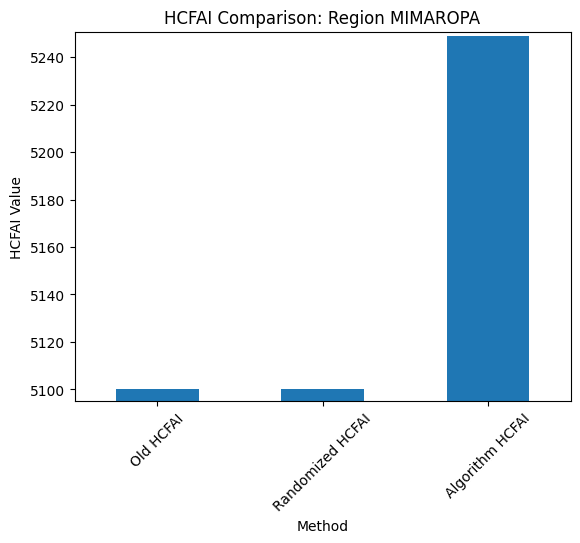

In [ ]:
hcfai_compare_df =  pd.DataFrame(
    {' ': ['SUM'],
    'Old HCFAI': og_HCFAI,
     'Randomized HCFAI': highest_rdm_HCFAI,
     'Algorithm HCFAI': updated_HCFAI
    })

import matplotlib.pyplot as plt
# Preparing the data for plotting
# Since we have only one row with label 'SUM', we'll use it as index
hcfai_compare_df.set_index(' ', inplace=True)
hcfai_compare_df = hcfai_compare_df.transpose()  # Transpose for easier plotting

# Plotting the bar chart
hcfai_compare_df.plot(kind='bar', legend=False)
plt.title(f'HCFAI Comparison: Region {region}')
plt.ylabel('HCFAI Value')
plt.ylim(min([og_HCFAI, highest_rdm_HCFAI, updated_HCFAI])-5, max([og_HCFAI, highest_rdm_HCFAI, updated_HCFAI])+2)
plt.xlabel('Method')
plt.xticks(rotation=45)
plt.show()

# Validation - trained mimaropa model

4998.420051360463
101.62131301202923
5001.484564998766
98.55679937372555
4997.719316487327
102.322047885165
5000.265039525954
99.77632484653694
5002.657170446488
97.38419392600355
4996.333315459728
103.70804891276397
5000.218461303133
99.82290306935862
4998.545033066403
101.4963313060883
5005.203313335077
94.83805103741494
5001.585517375476
98.45584699701499
Average HCFAI after randomization:  5100.0413643724905
=========== OG HCFAI RESULTS ===========
ORIGINAL HCFAI 5100.041364372491
=========== RANDOM HCFAI RESULTS ===========
RANDOMIZED HCFAI [10-fold]:  5100.0413643724905
=========== OPTIMIZED HCFAI RESULTS ===========
OPTIMIZED HCFAI  5172.638321499957


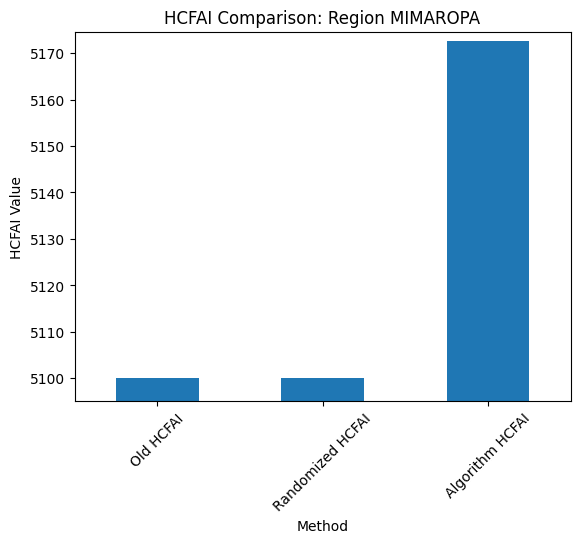

In [ ]:
import random
import pandas as pd

def getRandom48(candidate_sites, random_seed=None):
    """
    Randomly select 48 sites from the candidate sites DataFrame.

    Parameters:
        candidate_sites (DataFrame): DataFrame containing information about all candidate sites.
        random_seed (int): Random seed for reproducibility.

    Returns:
        DataFrame: Randomly selected 48 sites DataFrame.
    """
    if random_seed is not None:
        random.seed(random_seed)
    candidate_sites_shuffled = candidate_sites.sample(frac=1).reset_index(drop=True)
    random_48 = candidate_sites_shuffled.sample(n=PCF)
    return random_48

def randomize(region_df, candidate_sites, random_seed):
    """
    Randomize the selection of 48 sites and update the overall HCFAI value.
    Parameters:
        region_df (DataFrame): DataFrame containing information about all sites in the region.
    Returns:
        tuple: Tuple containing the updated overall HCFAI value and the IDs of randomly selected sites.
    """
    HCFAI_overall_before = overallHCFAI(region_df)
    # print("Overall HCFAI (before randomization): ", HCFAI_overall_before)
    random_48 = getRandom48(candidate_sites, random_seed)
    columns_to_merge = ['ID',
                        'popden_chi', 'popden_eld', 'popden_wom', 'popden_you', 'popden_w_1',
                        'popden_all', 'flood_probability_value', 'rain intensity_value',
                        'drought_value', 'buildability_landcov', 'RHU_Presence',
                        'Road_Presence', 'POI_Presence', 'Nearest_RHU',
                        'Distance_to_Nearest_RHU_km', 'HCFAI', 'total_population']
    merged_sites = random_48.merge(region_df[columns_to_merge], on='ID', how='left')
    missing_cols = [col for col in region_df.columns if col != ['ID']]
    for col in missing_cols:
        if 'ID' not in region_df.columns:
            region_df.set_index('ID', inplace=True)
        merged_sites[col] = merged_sites[col].fillna(region_df[col])
    # Calculate HCFAI for the remaining sites in region_df
    remaining_sites = region_df[~region_df['ID'].isin(merged_sites['ID'])]
    remaining_HCFAI = overallHCFAI(remaining_sites)
    print(remaining_HCFAI)
    selected_sites_HCFAI = overallHCFAI(merged_sites)
    print(selected_sites_HCFAI)

    # Calculate updated overall HCFAI
    updated_HCFAI = remaining_HCFAI + selected_sites_HCFAI
    # print(f"Updated HCFAI: ", updated_HCFAI)
    return updated_HCFAI, random_48['ID'].tolist()

# Example usage
rdm_hcfai = []
rdm_points = []
for i in range(10):
    random_seed = i  # Use a different random seed for each iteration
    rdm_ovHCFAI, rdm_48 = randomize(raw_rg1_clustered, candidate_sites, random_seed)
    rdm_hcfai.append(rdm_ovHCFAI)
    rdm_points.append(rdm_48)

rdm_HCFAI_avg = sum(rdm_hcfai) / len(rdm_hcfai)
highest_rdm_HCFAI = max(rdm_hcfai)
print("Average HCFAI after randomization: ", rdm_HCFAI_avg)

Results_rdmsum = pd.DataFrame({
    'Hex IDs': rdm_points,
    'HCFAI': rdm_hcfai
})

print("=========== OG HCFAI RESULTS ===========")
print("ORIGINAL HCFAI", og_HCFAI)
print("=========== RANDOM HCFAI RESULTS ===========")
# print("RANDOMIZED HCFAI [All, 10-fold]", rdm_hcfai)
print("RANDOMIZED HCFAI [10-fold]: ", rdm_HCFAI_avg)
# print("RANDOMIZED HCFAI AVG[10 fold]: ", rdm_HCFAI_avg)
print("=========== OPTIMIZED HCFAI RESULTS ===========")
print("OPTIMIZED HCFAI ", updated_HCFAI)

hcfai_compare_df =  pd.DataFrame(
    {' ': ['SUM'],
    'Old HCFAI': og_HCFAI,
     'Randomized HCFAI': highest_rdm_HCFAI,
     'Algorithm HCFAI': updated_HCFAI
    })

import matplotlib.pyplot as plt
# Preparing the data for plotting
# Since we have only one row with label 'SUM', we'll use it as index
hcfai_compare_df.set_index(' ', inplace=True)
hcfai_compare_df = hcfai_compare_df.transpose()  # Transpose for easier plotting

# Plotting the bar chart
hcfai_compare_df.plot(kind='bar', legend=False)
plt.title(f'HCFAI Comparison: Region {region}')
plt.ylabel('HCFAI Value')
plt.ylim(min([og_HCFAI, highest_rdm_HCFAI, updated_HCFAI])-5, max([og_HCFAI, highest_rdm_HCFAI, updated_HCFAI])+2)
plt.xlabel('Method')
plt.xticks(rotation=45)
plt.show()